In [1]:
%config Completer.use_jedi = False
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *

print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]

print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(fn_h5ad)
print('normalize data to CPM (counts per million)')
sc.pp.normalize_total(adata, target_sum=1e6)
        
print('Restrict to interaction genes')
genes = np.unique(interactions)
genes = [i for i in genes if i in adata.var_names] # genes = genes - ['CCL3L3', 'CCL4L1', 'CCN6', 'KIR3DS1', 'YARS1']
adatag = adata[:, genes]

Load interaction
Load high-quality cells only
normalize data to CPM (counts per million)
Restrict to interaction genes


In [2]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']
from adata_utilis import split_adata
print('split adata to [sick/condition, dataset]')
adata_dic = split_adata(adata)

split adata to [sick/condition, dataset]


In [242]:
#### log2_fold_change S_dengue vs dengue
import anndataks

cell_types = ['T_cells', 'CD4_T_cells', 'CD8_T_cells']
cds = ['S_dengue', 'dengue']

results = {}
for cell_type in cell_types:
    if cell_type in adata.obs['cell_subtype_2'].unique():
        ct_obs = 'cell_subtype_2'
    elif cell_type in adata.obs['cell_type'].unique():
        ct_obs = 'cell_type'

    adata_ct = adata_children[adata_children.obs[ct_obs] == cell_type]
    
    adata_SD = adata_ct[adata_ct.obs['Condition'] == 'S_dengue']
    adata_D = adata_ct[adata_ct.obs['Condition'] == 'dengue']      

    results[cell_type] = anndataks.compare(adata_D, adata_SD) 
    # log1p=False 
    # log2_fold_change: adata_Sd vs adata_D

res = pd.DataFrame([])
for cell_type in cell_types:
    results[cell_type]['cell_type'] = [cell_type] * results[cell_type].shape[0]
    res = pd.concat([res, results[cell_type]] )
    
res.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_ks_no_filter.tsv', sep='\t')

In [16]:
T_pair = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_pair.tsv', sep='\t', index_col=['cell_type', 'gene'])
T_log2FC = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_log2FC.tsv', sep='\t', index_col=0)
cst_pair = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/pair.tsv', sep='\t', index_col=['cell_subtype_2', 'gene'])
cst_log2FC = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/log2FC.tsv', sep='\t', index_col=0)
T_cst_pair = cst_pair.loc[['CD4_T_cells', 'CD8_T_cells']]
T_cst_log2FC = cst_log2FC.loc[['CD4_T_cells', 'CD8_T_cells']]
pair = pd.concat([T_pair, T_cst_pair])
log2FC = pd.concat([T_log2FC, T_cst_log2FC])
pair.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_cells/pair.tsv', sep='\t')
log2FC.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_cells/log2FC.tsv', sep='\t')

pair = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_cells/pair.tsv', sep='\t', index_col='gene')
T = [pair[pair['cell_type'] == cell_type].sort_values('med_pair', ascending=False) for cell_type in ['T_cells', 'CD4_T_cells', 'CD8_T_cells']] 
pair = pd.concat(T)
pair.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_cells/pair.tsv', sep='\t')

In [27]:
res = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_ks_no_filter.tsv', sep='\t', index_col=['cell_type', 'gene'])
ex_genes = []
for gene in ['IGHV', 'IGHD', 'IGHJ', 'IGKV', 'IGKJ', 'IGLV', 'IGLJ', 'TCRAV', 'TRBV', 'TRAJ', 'TRBJ', 'AC00']:
    ex_genes = ex_genes + adata_children.var_names[adata_children.var_names.str.startswith(gene)].tolist()
    
res.reset_index(inplace=True)
res = res[~res['gene'].isin(ex_genes)]
res.set_index(['cell_type', 'gene'], inplace=True)

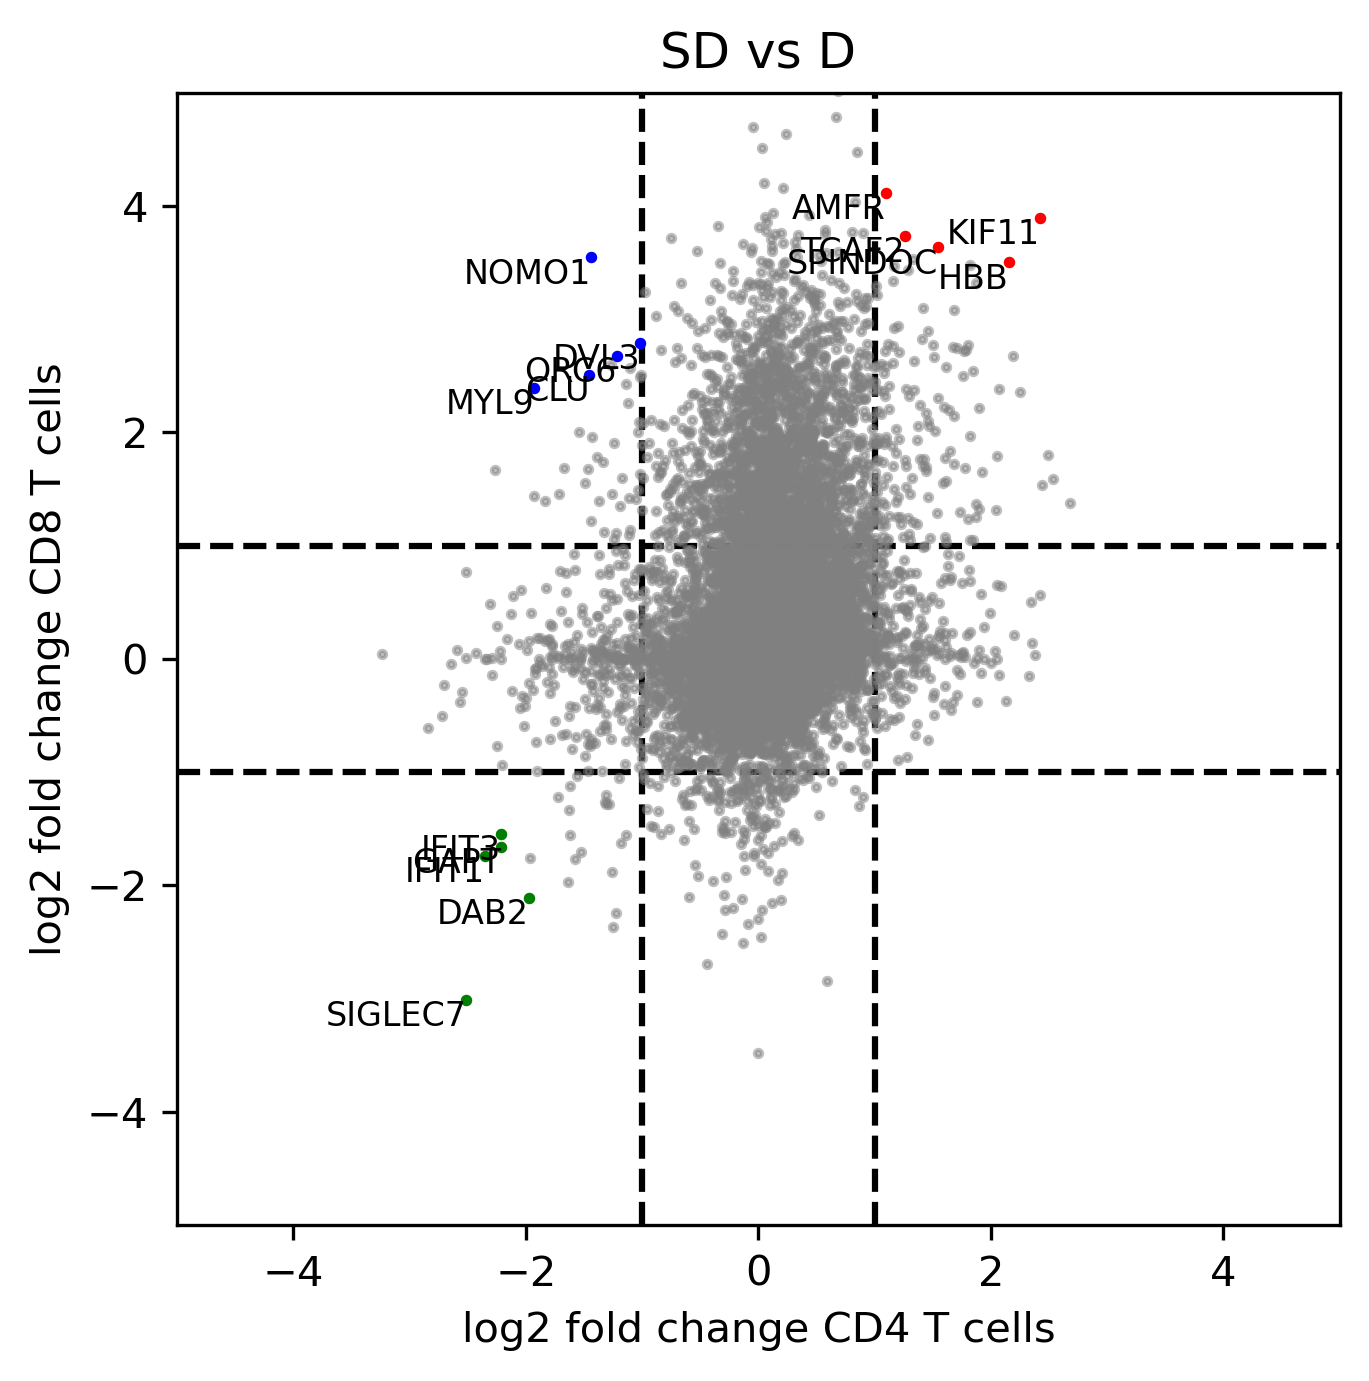

In [28]:
# scatter plot showing DEGs using pair comparison
fig, ax = plt.subplots(figsize=[5, 5], dpi=300)

res_CD4 = res.loc['CD4_T_cells']
res_CD8 = res.loc['CD8_T_cells'].loc[res_CD4.index]

x = res_CD4['mean_log2fc'].tolist()
y = res_CD8['mean_log2fc'].tolist()
ax.scatter(x, y, s=3, c='gray', alpha=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.set_xlabel('log2 fold change CD4 T cells')
ax.set_ylabel('log2 fold change CD8 T cells')
ax.set_title('SD vs D')

r1, r2, r3, r4 = [], [], [], []
for i, gene in enumerate(res_CD4.index.tolist()):
    ri = ((x[i])**2 + (y[i])**2)**0.5
    if x[i] > 1 and y[i] > 1:
        r1.append([gene, ri])
    elif x[i] < -1 and y[i] > 1:
        r2.append([gene, ri])
    elif x[i] < -1 and y[i] < -1:
        r3.append([gene, ri])
    elif x[i] > 1 and y[i] < -1:
        r4.append([gene, ri])

for i in [-1, 1]:
    ax.axvline(i, c='black', zorder=-5, ls='--')
    ax.axhline(i, c='black', zorder=-5, ls='--')

genes = {}      
for i, (r, color) in enumerate(zip([r1, r2, r3, r4], ['red', 'blue', 'green', 'orange'])):
    r = pd.DataFrame(r, columns=['gene', 'r']).set_index('gene').sort_values('r')
    genes[i] = r.tail(5).index.tolist()
    mark_x = [res_CD4['mean_log2fc'].loc[gene] for gene in genes[i]]
    mark_y = [res_CD8['mean_log2fc'].loc[gene] for gene in genes[i]]
    for gene, x, y in zip(genes[i], mark_x, mark_y):
        ax.text(x, y, gene, c='black', fontsize=8, ha='right', va='top')
    ax.scatter(mark_x, mark_y, c=color, s=3)

In [29]:
ls = genes[0] + genes[1] + genes[2]
plot_genes = [{gene: ['CD4_T_cells', 'CD8_T_cells']} for gene in ls]

In [3]:
def s_mushrooms(genes):
    '''
    genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['cDCs'],
          'ICAM1': ['Plasmablasts']},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['pDCs']}]
    '''
    from matplotlib.patches import Wedge
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math
    import numpy as np
    import pandas as pd
    import itertools

    conditions = ['S_dengue', 'dengue']
    cmap = plt.cm.get_cmap('viridis')
    vmin, vmax = -1, 3
    threshold = 0.05
    frac_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/fra.tsv', 
                      sep='\t', index_col=['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    avg_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/avg.tsv', sep='\t',
                      index_col=['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    
    frac_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/ct_fra.tsv', sep='\t',
                          index_col=['cell_type', 'condition', 'gene'], squeeze=True)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/ct_avg.tsv', sep='\t',
                         index_col=['cell_type', 'condition', 'gene'], squeeze=True)

    yl = sum([len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes])
    fig = plt.figure(figsize=((1 + 0.8 * 2) * 0.6, (1 + yl)* 0.6), dpi=300)

    grid = plt.GridSpec(yl , 2, wspace=1.1, hspace=1.1)
    
    cell_types = ['B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs', 'Monocytes', 'Plasmablasts']
    cell_subtypes = ['Naive_B_cells', 'NK', 'CD4_T_cells', 'NKT', 'Memory_B_cells', 'CD8_T_cells',
                     'Macrophages', 'non_classical_monocytes', 'IgA', 'IgG1_proliferate', 'pDCs',
                     'cDC_IFN', 'Classical_monocytes', 'IgG1_IgG2', 'cDC2', 'IgG1', 'IgM', 'cDC1']

    axs = []
    for i in range(len(genes)):
         axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
    size_bar = plt.subplot(grid[0: 5, 1: 2])

    datap = []
    for genesi, ax in zip(genes, axs):
        cts = list(genesi.values())
        gs = list(genesi.keys())
        yticklabels = []
        for i, (csts, gene) in enumerate(zip(cts, gs)):
            for cst in csts:
                avgs = []
                yticklabels.append(cst.replace('_', ' ')) #
                for k, cond in enumerate(conditions):
                    if cst in cell_types:
                        fr = frac_ct.loc[(cst, cond, gene)]
                        av = np.log10(avg_ct.loc[(cst, cond, gene)] + 0.1)
                    elif cst in cell_subtypes:
                        fr = frac_cst.loc[(cst, cond, gene)]
                        av = np.log10(avg_cst.loc[(cst, cond, gene)] + 0.1)
                    avgs.append(av)

                    r = 0.5 * fr**0.3
                    color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                    theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                    datap.append({
                        'r': r,
                        'facecolor': color,
                        'center': (0, len(yticklabels)-1),
                        'theta': (theta0, theta1),
                        'ax': ax,
                    })
                if avgs[0] - avgs[1] > threshold:
                    datap[-2]['edgecolor'] = 'red'
                    datap[-1]['edgecolor'] = 'none'
                elif avgs[0] - avgs[1] < -threshold:
                    datap[-1]['edgecolor'] = 'red'
                    datap[-2]['edgecolor'] = 'none'
                else:
                    datap[-1]['edgecolor'] = 'none'
                    datap[-2]['edgecolor'] = 'none'   


        ax.set_yticks(np.arange(len(list(itertools.chain.from_iterable(genesi.values())))))
        ax.set_yticklabels(yticklabels)
        ax.set_ylim(-0.6, len(list(itertools.chain.from_iterable(genesi.values()))) - 0.4)        
        ax.set_xticks([])
        ax.set_title(gene, loc='left')
        ax.set_xlim(-0.6, 1 - 0.4)

    for datum in datap:
        ax = datum['ax']
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, facecolor=color, edgecolor=ec
        )
        ax.add_artist(h)
        ax.set_aspect(1)

    size_bar.set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        size_bar.add_artist(e)
    size_bar.set_aspect(1)
    size_bar.set_yticks([])
    size_bar.set_yticks(range(5))
    size_bar.set_yticklabels(['5', '10', '20', '40', '80'])
    size_bar.yaxis.tick_right()
    size_bar.yaxis.set_label_position('right')
    size_bar.set_ylabel('Gene exp frac')
    size_bar.set_xticks([])
    size_bar.spines['bottom'].set_visible(False)
    size_bar.spines['top'].set_visible(False)
    size_bar.spines['right'].set_visible(False)
    size_bar.spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.7, 0.2, 0.05, 2/yl])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=axs[-1], label='Gene exp \n(log10[cpm+0.1])')

    fig.tight_layout()
    return {'fig': fig, 'ax': axs}

<ipython-input-42-bf16d6532557>:42: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-42-bf16d6532557>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x5580 with 17 Axes>,
 'ax': [<AxesSubplot:title={'left':'TCAF2'}>,
  <AxesSubplot:title={'left':'SPINDOC'}>,
  <AxesSubplot:title={'left':'HBB'}>,
  <AxesSubplot:title={'left':'AMFR'}>,
  <AxesSubplot:title={'left':'KIF11'}>,
  <AxesSubplot:title={'left':'CLU'}>,
  <AxesSubplot:title={'left':'ORC6'}>,
  <AxesSubplot:title={'left':'DVL3'}>,
  <AxesSubplot:title={'left':'MYL9'}>,
  <AxesSubplot:title={'left':'NOMO1'}>,
  <AxesSubplot:title={'left':'IFIT3'}>,
  <AxesSubplot:title={'left':'GAPT'}>,
  <AxesSubplot:title={'left':'DAB2'}>,
  <AxesSubplot:title={'left':'IFIT1'}>,
  <AxesSubplot:title={'left':'SIGLEC7'}>]}

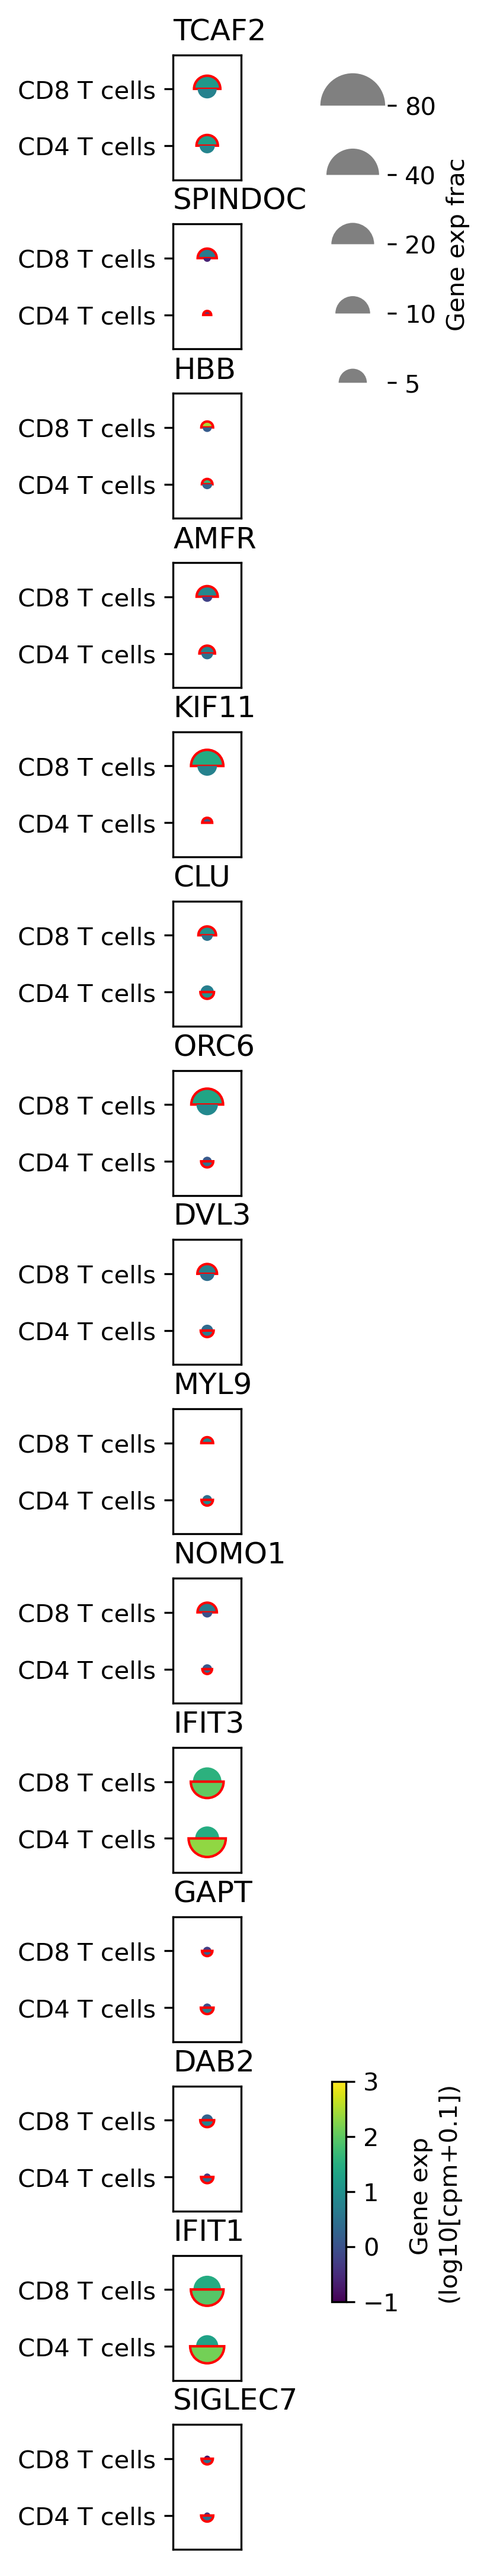

In [43]:
s_mushrooms(plot_genes)

<ipython-input-3-bf16d6532557>:42: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-3-bf16d6532557>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1620 with 6 Axes>,
 'ax': [<AxesSubplot:title={'left':'IL2RA'}>,
  <AxesSubplot:title={'left':'CTLA4'}>,
  <AxesSubplot:title={'left':'FOXP3'}>,
  <AxesSubplot:title={'left':'CD28'}>]}

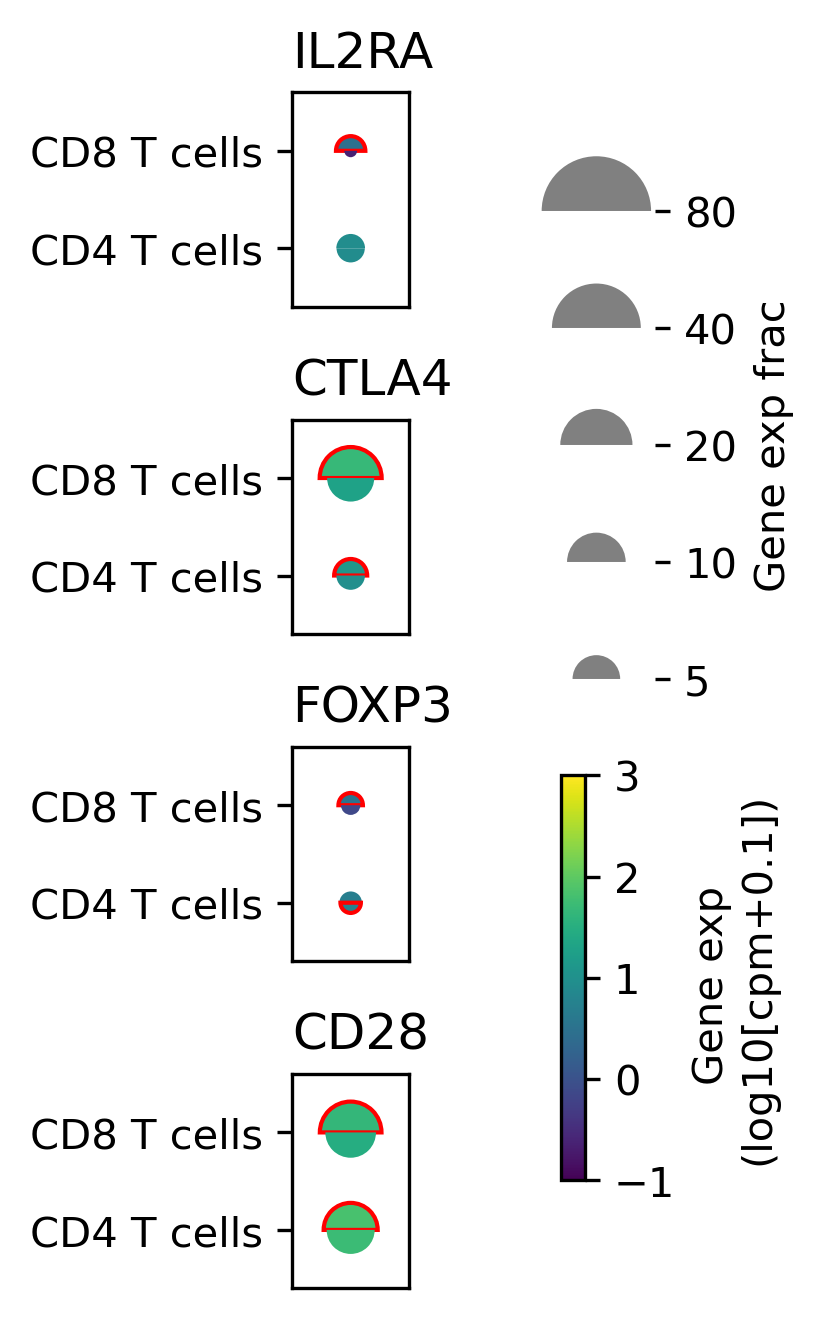

In [6]:
s_mushrooms([{'IL2RA': ['CD4_T_cells', 'CD8_T_cells']},
             {'CTLA4': ['CD4_T_cells', 'CD8_T_cells']},
             {'FOXP3': ['CD4_T_cells', 'CD8_T_cells']},
             {'CD28': ['CD4_T_cells', 'CD8_T_cells']}
            ])

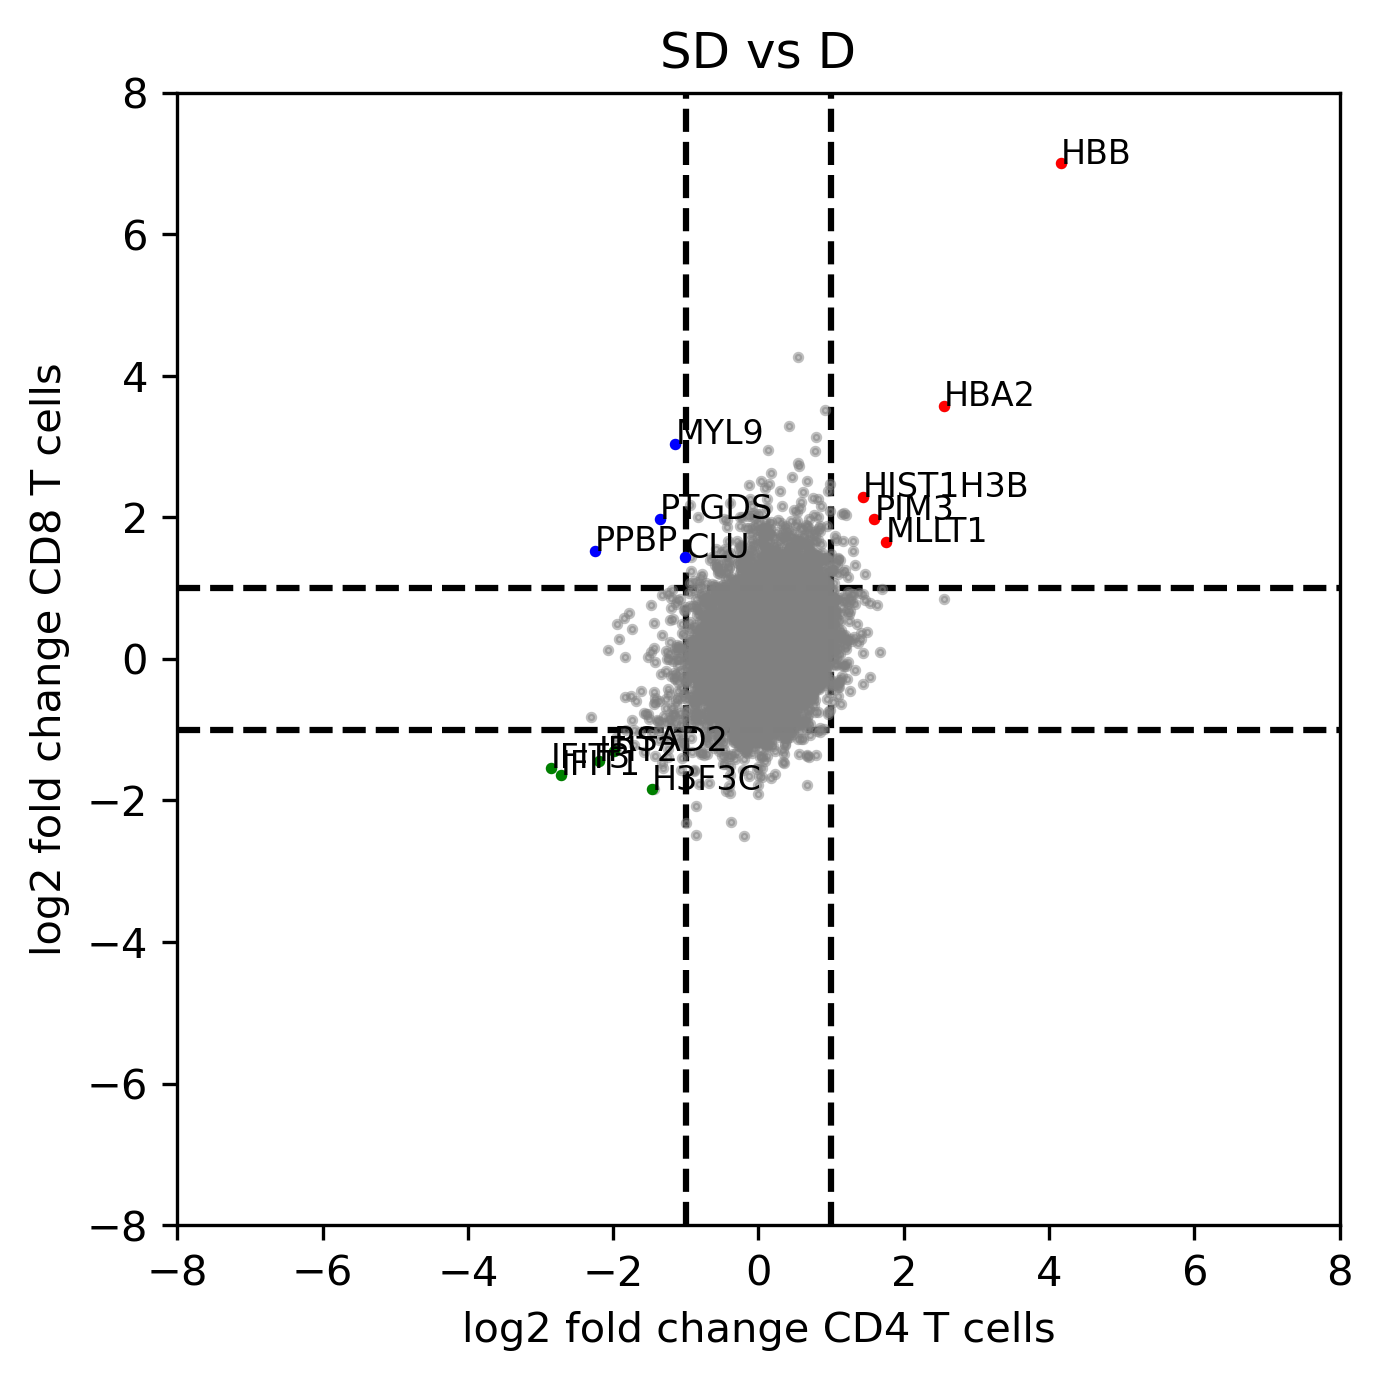

In [44]:
# scatter plot showing DEGs using log2 fold change
fig, ax = plt.subplots(figsize=[5, 5], dpi=300)

res_CD4 = res.loc['CD4_T_cells']
res_CD8 = res.loc['CD8_T_cells'].loc[res_CD4.index]

x = res_CD4['log2_fold_change'].tolist()
y = res_CD8['log2_fold_change'].tolist()
ax.scatter(x, y, s=3, c='gray', alpha=0.5)
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

ax.set_xlabel('log2 fold change CD4 T cells')
ax.set_ylabel('log2 fold change CD8 T cells')
ax.set_title('SD vs D')

r1, r2, r3, r4 = [], [], [], []
for i, gene in enumerate(res_CD4.index.tolist()):
    ri = ((x[i])**2 + (y[i])**2)**0.5
    if x[i] > 1 and y[i] > 1:
        r1.append([gene, ri])
    elif x[i] < -1 and y[i] > 1:
        r2.append([gene, ri])
    elif x[i] < -1 and y[i] < -1:
        r3.append([gene, ri])
    elif x[i] > 1 and y[i] < -1:
        r4.append([gene, ri])

for i in [-1, 1]:
    ax.axvline(i, c='black', zorder=-5, ls='--')
    ax.axhline(i, c='black', zorder=-5, ls='--')

genes = {}      
for i, (r, color) in enumerate(zip([r1, r2, r3, r4], ['red', 'blue', 'green', 'orange'])):
    r = pd.DataFrame(r, columns=['gene', 'r']).set_index('gene').sort_values('r')
    genes[i] = r.tail(5).index.tolist()
    mark_x = [res_CD4['log2_fold_change'].loc[gene] for gene in genes[i]]
    mark_y = [res_CD8['log2_fold_change'].loc[gene] for gene in genes[i]]
    for gene, x, y in zip(genes[i], mark_x, mark_y):
        ax.text(x, y, gene, c='black', fontsize=8)
    ax.scatter(mark_x, mark_y, c=color, s=3)

In [312]:
def scatter_plot(cell_type, res):
    fig, ax = plt.subplots(figsize=[10, 10], dpi=100)
    x = res.loc[cell_type]['log2_fold_change'].tolist()
    y = -np.log10(res.loc[cell_type]['pvalue'].tolist())
    ax.scatter(x, y, s=1, c='gray')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-10, 150)
    ax.axvline(-1, c='black', zorder=-5, ls='--')
    ax.axvline(1, c='black', zorder=-5, ls='--')
    ax.axhline(10, c='black', zorder=-5, ls='--')
    ax.set_xlabel('log2_fold_change')
    ax.set_ylabel('-log10P')
    ax.set_title(cell_type)
    
    genes = []
    mark_x = []
    mark_y = []
    
    for i, (gene, xi, yi) in enumerate(zip(res.loc[cell_type].index.tolist(), x, y)):
        if (x[i] > 1 and y[i] > 10) | (x[i] < -1 and y[i] > 10):
            genes.append(gene)
            mark_x.append(xi)
            mark_y.append(yi)
            
#   for g, color in zip([g1, g2], ['orange', 'blue']):
    for gene, x, y in zip(genes, mark_x, mark_y):
        ax.text(x, y, gene, c='black', fontsize=5)
    ax.scatter(mark_x, mark_y, c='orange', s=2)

    return {'fig': fig, 'ax': ax}

In [496]:
frac_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/fra.tsv', 
                  sep='\t', index_col=['cell_subtype_2', 'condition', 'gene'])
avg_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/avg.tsv', sep='\t',
                  index_col=['cell_subtype_2', 'condition', 'gene'])

frac_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/ct_fra.tsv', sep='\t',
                      index_col=['cell_type', 'condition', 'gene'])
avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/ct_avg.tsv', sep='\t',
                     index_col=['cell_type', 'condition', 'gene'])

In [494]:
res['med_pair'] = pair.loc[res.index]['med_pair'].tolist()
res['fra_pair'] = pair.loc[res.index]['fra_pair'].tolist()
res['mean_log2fc'] = (res['log2_fold_change'] + res['med_pair'])/2

In [501]:
T_idx1 = [('T_cells', 'dengue', idx) for idx in res.loc['T_cells'].index]
T_idx2 = [('T_cells', 'S_dengue', idx) for idx in res.loc['T_cells'].index]

CD4_idx1 = [('CD4_T_cells', 'dengue', idx) for idx in res.loc['CD4_T_cells'].index]
CD4_idx2 = [('CD4_T_cells', 'S_dengue', idx) for idx in res.loc['CD4_T_cells'].index]

CD8_idx1 = [('CD8_T_cells', 'dengue', idx) for idx in res.loc['CD8_T_cells'].index]
CD8_idx2 = [('CD8_T_cells', 'S_dengue', idx) for idx in res.loc['CD8_T_cells'].index]

res['fra1'] = frac_ct.loc[T_idx1]['fra'].tolist() + frac_cst.loc[CD4_idx1]['fra'].tolist() + frac_cst.loc[CD8_idx1]['fra'].tolist() 
        
res['fra2'] = frac_ct.loc[T_idx2]['fra'].tolist() + frac_cst.loc[CD4_idx2]['fra'].tolist() + frac_cst.loc[CD8_idx2]['fra'].tolist() 

In [503]:
res.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_ks_no_filter.tsv', sep='\t')

In [564]:
res

statistic  pvalue  avg1      avg2  log2_fold_change  \
cell_type                                                                      
T_cells     MIR1302-2HG   0.000000     1.0   0.0  0.000000          0.000000   
            FAM138A       0.000000     1.0   0.0  0.000000          0.000000   
            OR4F5         0.000000     1.0   0.0  0.000000          0.000000   
            AL627309.1    0.000321     1.0   0.0  0.144565          0.144565   
            AL627309.3    0.000000     1.0   0.0  0.000000          0.000000   
...                            ...     ...   ...       ...               ...   
CD8_T_cells AC005911.1    0.000000     1.0   0.0  0.000000          0.000000   
            REXO4_1       0.000000     1.0   0.0  0.000000          0.000000   
            AC079922.1    0.000000     1.0   0.0  0.000000          0.000000   
            CHCHD2P6      0.000000     1.0   0.0  0.000000          0.000000   
            RAB43P1       0.000000     1.0   0.0  0.000000          0.000000   

                          avg_avg  med_pair  fra_pair  mean_log2fc  fra1  \
cell_type                                                                  
T_cells     MIR1302-2HG  0.000000       0.0      0.00     0.000000   0.0   
            FAM138A      0.000000       0.0      0.00     0.000000   0.0   
            OR4F5        0.000000       0.0      0.00     0.000000   0.0   
            AL627309.1   0.072282       0.0      0.25     0.072282   0.0   
            AL627309.3   0.000000       0.0      0.00     0.000000   0.0   
...                           ...       ...       ...          ...   ...   
CD8_T_cells AC005911.1   0.000000       0.0      0.00     0.000000   0.0   
            REXO4_1      0.000000       0.0      0.00     0.000000   0.0   
            AC079922.1   0.000000       0.0      0.00     0.000000   0.0   
            CHCHD2P6     0.000000       0.0      0.00     0.000000   0.0   
            RAB43P1      0.000000       0.0      0.00     0.000000   0.0   

                             fra2  
cell_type                          
T_cells     MIR1302-2HG  0.000000  
            FAM138A      0.000000  
            OR4F5        0.000000  
            AL627309.1   0.000321  
            AL627309.3   0.000000  
...                           ...  
CD8_T_cells AC005911.1   0.000000  
            REXO4_1      0.000000  
            AC079922.1   0.000000  
            CHCHD2P6     0.000000  
            RAB43P1      0.000000  

[113721 rows x 11 columns]

In [575]:
ex_genes = []
for gene in ['IGHV', 'IGHD', 'IGHJ', 'IGKV', 'IGKJ', 'IGLV', 'IGLJ', 'TCRAV', 'TRBV', 'TRAJ', 'TRBJ']:
    ex_genes = ex_genes + adata_children.var_names[adata_children.var_names.str.startswith(gene)].tolist()
    
res.reset_index(inplace=True)
res = res[~res['level_1'].isin(ex_genes)]
res.set_index(['cell_type', 'level_1'], inplace=True)

In [589]:
def exp_thre(n, cell_type):    
    res_new = res[res['avg_avg'] > n]

    log2FC = res.loc[cell_type].loc[res_new.loc[cell_type].index]['log2_fold_change'].tolist()
    m_log2FC = pair.loc[cell_type].loc[res_new.loc[cell_type].index]['med_pair'].tolist()

    from scipy.stats import spearmanr
    print(spearmanr(log2FC, m_log2FC))
    plt.scatter(log2FC, m_log2FC) # mean of log2FC, m_log2FC
    return res_new

In [590]:
def data_ct(res_new, cell_type):    
    data_T = res.loc[cell_type].loc[res_new.loc[cell_type].index]
    data_T.sort_values('mean_log2fc', ascending=False, inplace=True)
    return data_T

In [591]:
def mush_top10(data_T):
    #data_T = data_T[data_T['fra2'] > 0.05]
    
    T_up = data_T.head(10)
    T_top_genes = []
    for i, gene in enumerate(T_up.index.tolist()):
        T_top_genes.append({})
        T_top_genes[i][gene] = ['T_cells']
    return s_mushrooms(T_top_genes)

def mush_last10(data_T):
    #data_T = data_T[data_T['fra1'] > 0.05]
    T_down = data_T.tail(10)
    T_last_genes = []
    for i, gene in enumerate(T_down.index.tolist()):
        T_last_genes.append({})
        T_last_genes[i][gene] = ['T_cells']
    return s_mushrooms(T_last_genes)

SpearmanrResult(correlation=0.8797944858316485, pvalue=0.0)


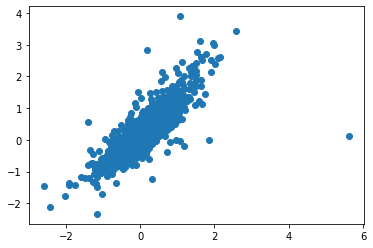

In [587]:
res_T = exp_thre(3, 'T_cells')

In [592]:
data_T = data_ct(res_T, 'T_cells')

<ipython-input-379-1513e3272b80>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1980 with 12 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

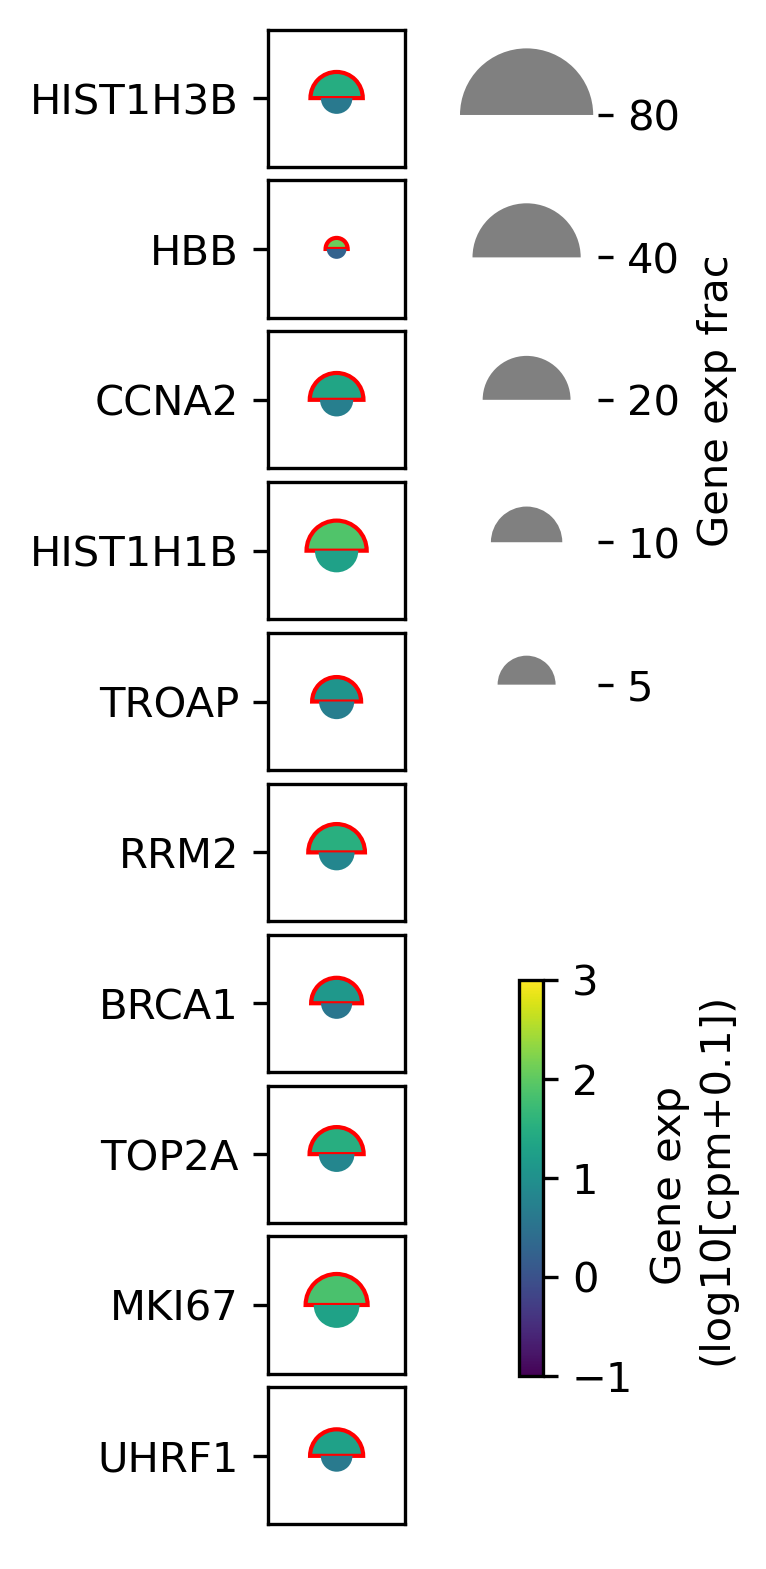

In [593]:
mush_top10(data_T)

<ipython-input-379-1513e3272b80>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1980 with 12 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

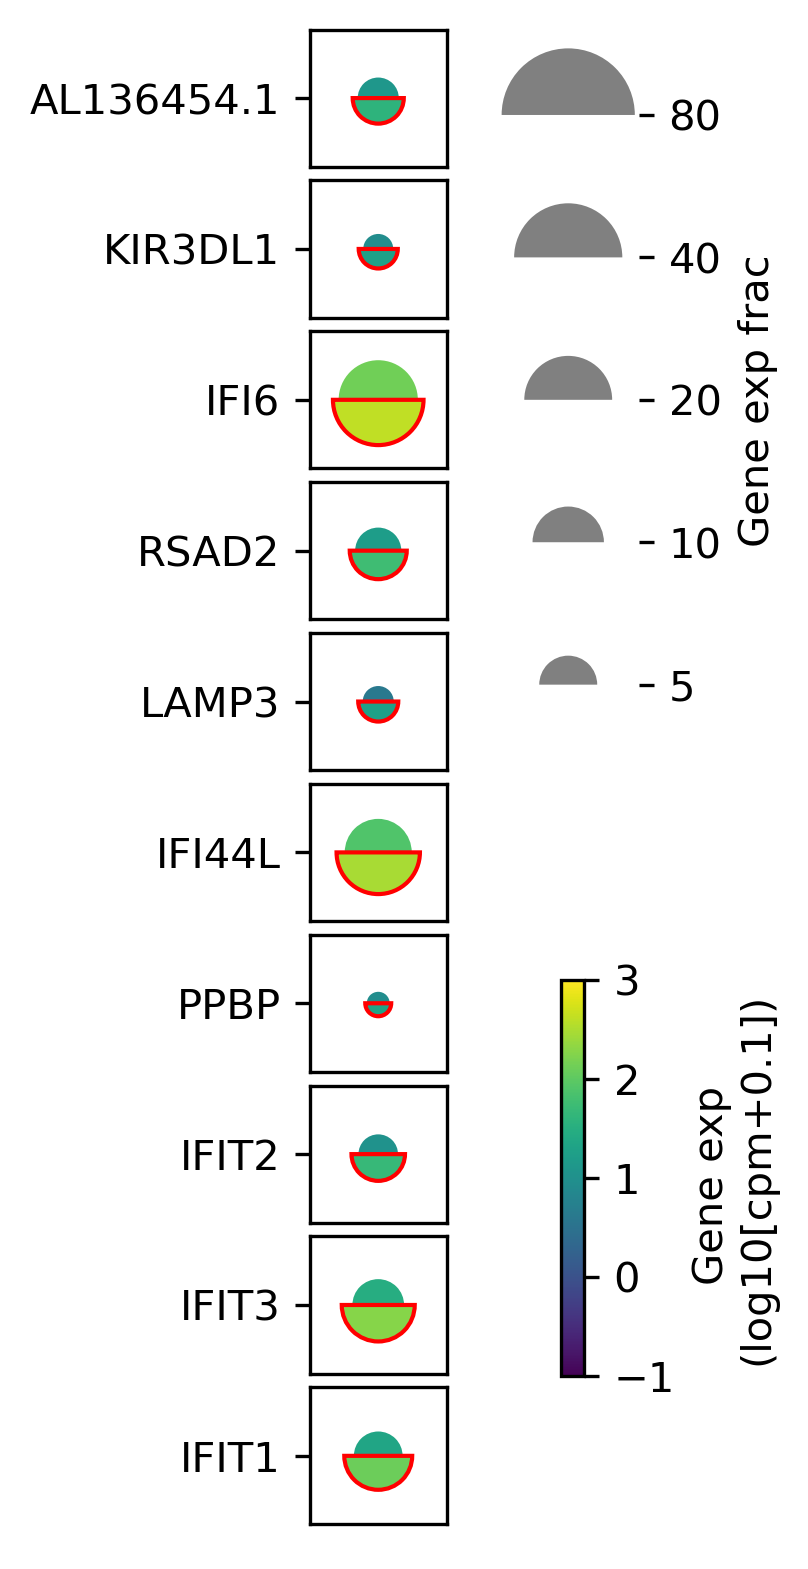

In [594]:
mush_last10(data_T)

In [610]:
data_T.head(501).index.tolist()

['HIST1H3B',
 'HBB',
 'CCNA2',
 'HIST1H1B',
 'TROAP',
 'RRM2',
 'BRCA1',
 'TOP2A',
 'MKI67',
 'UHRF1',
 'UBE2C',
 'BIRC5',
 'CENPE',
 'TPX2',
 'NUSAP1',
 'CDK1',
 'CENPW',
 'KIFC1',
 'ASPM',
 'GTSE1',
 'TK1',
 'WDR34',
 'CDCA8',
 'CENPF',
 'CENPU',
 'GINS2',
 'CLSPN',
 'DLGAP5',
 'HELLS',
 'COTL1',
 'CDC20',
 'CDT1',
 'FANCI',
 'MCM2',
 'PKMYT1',
 'CCNB2',
 'PLK1',
 'IGHG3',
 'ASF1B',
 'CCNB1',
 'MCM4',
 'FEN1',
 'TYMS',
 'ZWINT',
 'HIST1H4C',
 'PIM3',
 'ATAD5',
 'TIMD4',
 'CDCA7',
 'DHFR',
 'PTMS',
 'HMGB3',
 'CDKN3',
 'SRM',
 'FBXO5',
 'IFNG',
 'CCL4L2',
 'CTLA4',
 'HIST2H2AB',
 'LMNB1',
 'PSAT1',
 'TCF19',
 'TCAF2',
 'PNPLA6',
 'NSD2',
 'SGO2',
 'WBP1L',
 'IGHG4',
 'SLC1A5',
 'EGR1',
 'ANKRD52',
 'PTTG1',
 'MCM7',
 'HIST1H1D',
 'MYO5A',
 'NCAPG2',
 'ATAD2',
 'CENPM',
 'GPRIN3',
 'NCAPD2',
 'SACS',
 'UCK2',
 'MCM6',
 'USP7',
 'LPCAT1',
 'DDX11',
 'JAK3',
 'HYOU1',
 'NDC80',
 'SEC16A',
 'JAKMIP1',
 'FABP5',
 'MIR4435-2HG',
 'LARP1',
 'ICMT',
 'PSPH',
 'H2AFX',
 'MED24',
 'VARS2',
 'GM

In [611]:
data_T.tail(501).index.tolist()

['FBLN7',
 'CNIH1',
 'ARHGAP5',
 'CTSW',
 'TMEM179B',
 'CCDC152',
 'SLC40A1',
 'MAIP1',
 'PARP10',
 'THOC3',
 'TIMP1',
 'ATP6V0E1',
 'BDH2',
 'GIMAP4',
 'UFSP2',
 'TVP23B',
 'ZNF581',
 'TMEM59',
 'ZNF140',
 'SERTAD3',
 'CYB5D2',
 'AC087239.1',
 'ST6GALNAC4',
 'CHIC2',
 'SS18L2',
 'COA5',
 'NDUFAF7',
 'LYPD3',
 'AP002748.3',
 'LEPROTL1',
 'IQCG',
 'SCARB2',
 'TMEM138',
 'RPP21',
 'OXSM',
 'TCEAL4',
 'AL357060.1',
 'SDHAF3',
 'BEX3',
 'DDX60',
 'DPM2',
 'SMIM8',
 'PTPRCAP',
 'TSR3',
 'TSTD1',
 'C11orf21',
 'MTIF3',
 'LINC02001',
 'TRAV13-2',
 'LRRC8C-DT',
 'CD40LG',
 'SNX6',
 'SMIM3',
 'C7orf50',
 'BUD13',
 'AC084033.3',
 'GLCE',
 'AC093323.1',
 'TM2D1',
 'UNC119',
 'NBDY',
 'ANAPC10',
 'TRGV5',
 'OSGEPL1',
 'ERN1',
 'TMEM62',
 'PNPT1',
 'ZNF429',
 'ZNF83',
 'ZNF383',
 'ZNF224',
 'TMEM60',
 'OASL',
 'LIN37',
 'AC136475.5',
 'LY9',
 'PPP2R5A',
 'THEMIS2',
 'LAPTM4A',
 'SMYD2',
 'CARD8-AS1',
 'AAMDC',
 'MED28',
 'CEP164',
 'LINC02084',
 'TMEM44-AS1',
 'TNFAIP8',
 'C4orf3',
 'CLUAP1',
 'DUS

SpearmanrResult(correlation=0.844911034059608, pvalue=0.0)


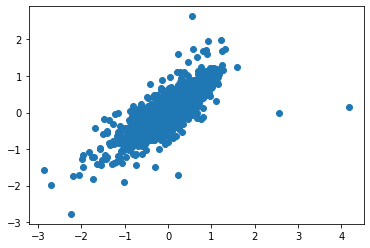

In [598]:
res_CD4 = exp_thre(3, 'CD4_T_cells')

In [599]:
data_CD4 = data_ct(res_CD4, 'CD4_T_cells')

In [612]:
data_CD4.head(501).index.tolist()

['HBB',
 'ARFGEF2',
 'IGHG3',
 'HIST1H1B',
 'C20orf204',
 'CSNK1G1',
 'PIM3',
 'EGR1',
 'GSTM1',
 'TCAF2',
 'IGLC3',
 'RALGAPA2',
 'JAK3',
 'UBXN6',
 'IGHG1',
 'SEC16A',
 'PLCB2',
 'GNS',
 'USP7',
 'SOCS3',
 'IGLC2',
 'SACS',
 'TAF4B',
 'DIP2B',
 'KLHL11',
 'SRM',
 'ANO9',
 'SEC23A',
 'VPS50',
 'COTL1',
 'GEMIN5',
 'NBPF15',
 'ICMT',
 'DHX37',
 'LATS1',
 'KLF7',
 'MADD',
 'GZMH',
 'MAN2B2',
 'LARP1',
 'FAM222B',
 'CHPF2',
 'PIK3R5',
 'SKI',
 'FKBP5',
 'AQR',
 'DOCK11',
 'ARID3B',
 'MAP1S',
 'PSPH',
 'MTMR3',
 'NIN',
 'CC2D1B',
 'KIF21B',
 'PNPLA6',
 'TUBB2A',
 'SIN3A',
 'XPOT',
 'TACC1',
 'ANK3',
 'TMEM120B',
 'NFKBIZ',
 'MKL2',
 'SUSD6',
 'RNF157',
 'ATP2A3',
 'SNX13',
 'PHF8',
 'TTN',
 'SMPD4',
 'ABCC1',
 'HIPK2',
 'ZZEF1',
 'CLIP4',
 'PDK1',
 'NSMAF',
 'CCDC88B',
 'TBC1D25',
 'MED1',
 'CTBP1-DT',
 'SYMPK',
 'TMEM189',
 'BRWD3',
 'RBM15',
 'GPRIN3',
 'EIF3B',
 'CAB39',
 'ZNF664',
 'MSL1',
 'PPAT',
 'SETD1B',
 'PSAT1',
 'RBM12',
 'HIST1H1D',
 'FBXO32',
 'SMG5',
 'CAMK1D',
 'INTS1',
 '

In [613]:
data_CD4.tail(501).index.tolist()

['SENP1',
 'PARP9',
 'AC093157.1',
 'AC093323.1',
 'CCDC34',
 'TCEAL3',
 'RAD51C',
 'OCEL1',
 'LAPTM4A',
 'TMEM191C',
 'TNFSF10',
 'STX5',
 'FOPNL',
 'EXOSC3',
 'BOD1',
 'TMEM102',
 'CCDC102B',
 'PADI4',
 'ZFYVE19',
 'NOG',
 'ZDHHC16',
 'ZNF720',
 'SSR4',
 'SNHG7',
 'STRN',
 'LINC00402',
 'GRN',
 'CYB5A',
 'LINC00324',
 'AKIP1',
 'HIBCH',
 'ZDHHC12',
 'TMEM199',
 'C22orf34',
 'PRKCA',
 'ZNF691',
 'ANXA4',
 'SNX11',
 'RBX1',
 'PSMB8',
 'PHRF1',
 'PSMB9',
 'CASP1',
 'NR2C2',
 'ENTPD3-AS1',
 'TIPIN',
 'URI1',
 'HOTAIRM1',
 'NUP35',
 'MRPL18',
 'TGDS',
 'IL2RG',
 'TMEM216',
 'AC109826.1',
 'PTPN12',
 'EIF1AY',
 'SRSF9',
 'RGS1',
 'BOLA2B',
 'FRG1',
 'EIF2B3',
 'CCR6',
 'TGIF1',
 'LINC00623',
 'ERN1',
 'AC009041.2',
 'SLC7A6OS',
 'TAF12',
 'TPM1',
 'SLC9A9',
 'GTF2H2C',
 'GLCE',
 'TIMMDC1',
 'SELENOI',
 'EFHD2',
 'PARVB',
 'VNN2',
 'DPAGT1',
 'CALHM2',
 'AC008105.3',
 'SCAMP1-AS1',
 'MRPS33',
 'PSMG4',
 'AC091271.1',
 'PHF23',
 'AC006213.2',
 'C1orf162',
 'GIN1',
 'COMMD7',
 'GZMK',
 'HMGN3

<ipython-input-379-1513e3272b80>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1980 with 12 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

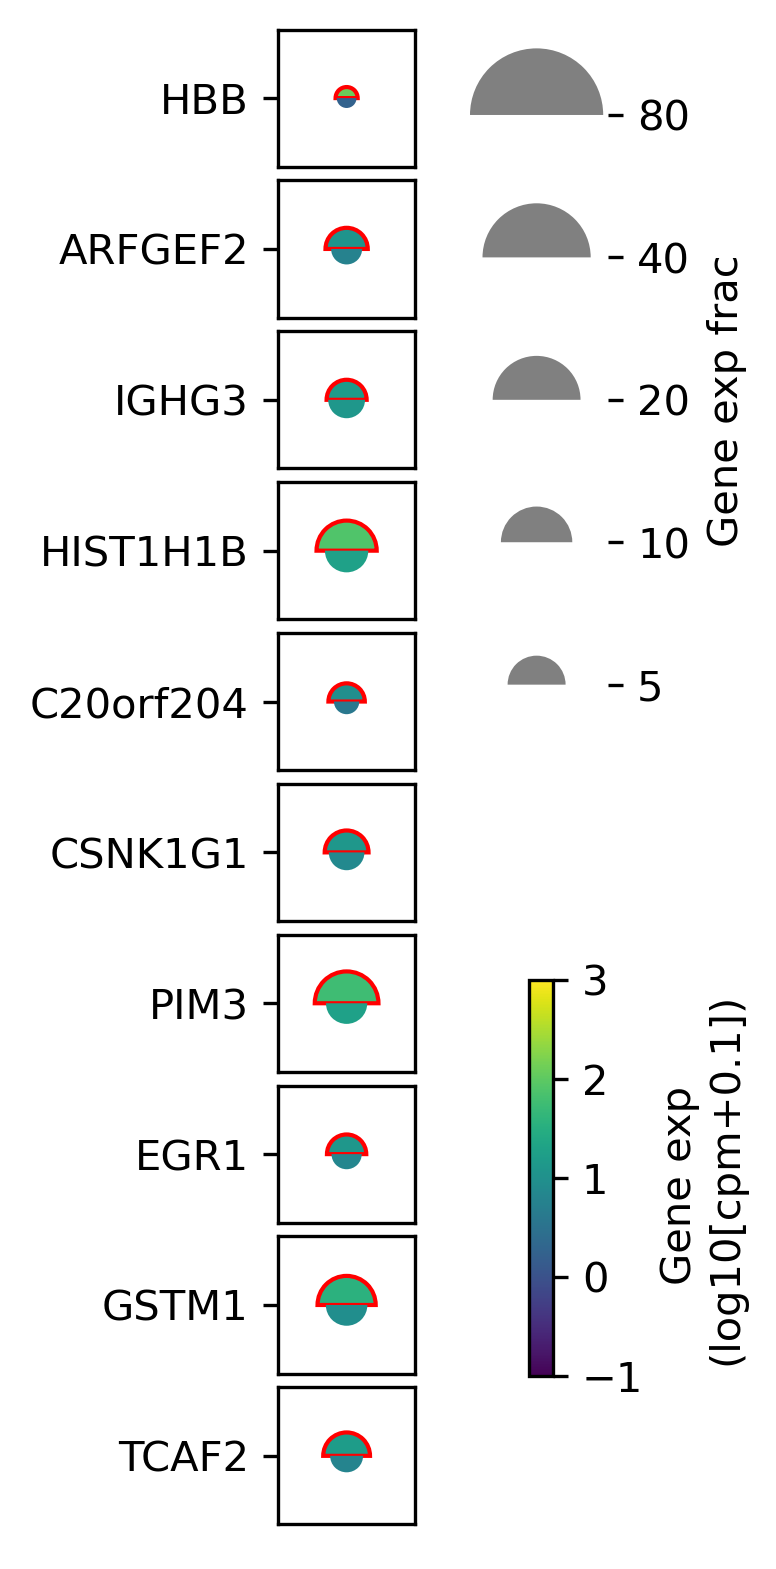

In [602]:
mush_top10(data_CD4)

<ipython-input-379-1513e3272b80>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1980 with 12 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

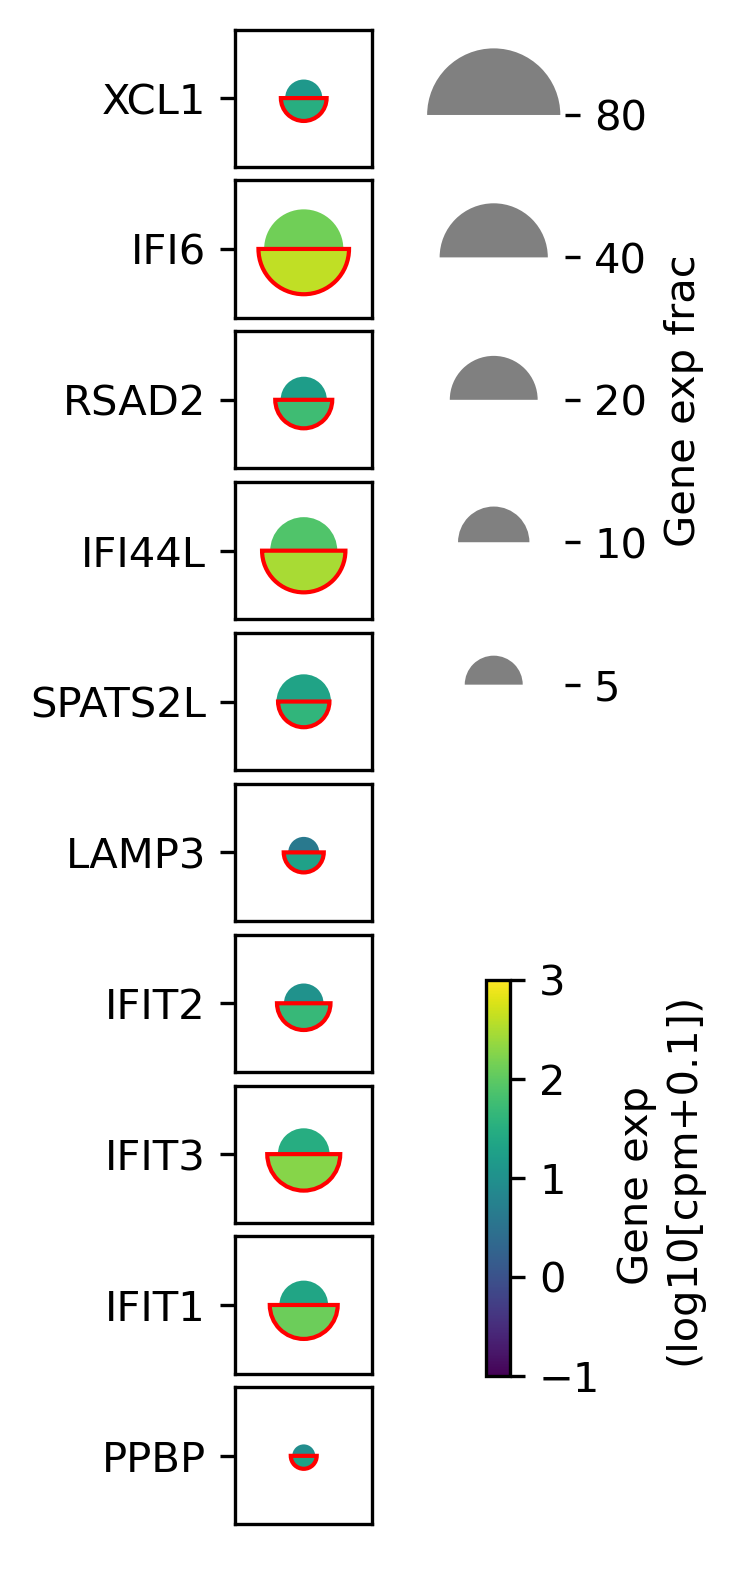

In [603]:
mush_last10(data_CD4)

SpearmanrResult(correlation=0.7490410501769194, pvalue=0.0)


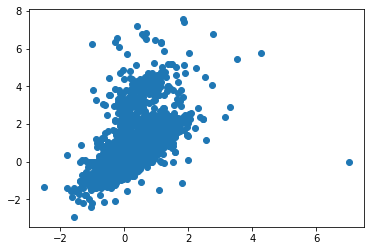

In [619]:
res_CD8 = exp_thre(3, 'CD8_T_cells')

In [605]:
data_CD8 = data_ct(res_CD8, 'CD8_T_cells')

In [614]:
data_CD8.head(501).index.tolist()

['HIST1H2AI',
 'ALYREF',
 'HIST1H2AL',
 'PROSER1',
 'HIST1H2AJ',
 'KIF11',
 'ZDHHC16',
 'PHGDH',
 'ASNS',
 'TCAF2',
 'CORO1C',
 'TRMT10A',
 'DBN1',
 'HSPA14-1',
 'RAVER1',
 'HIST1H4F',
 'CD4',
 'HBB',
 'HIST1H3C',
 'BCL3',
 'CLN6',
 'HIST1H2AB',
 'SHCBP1',
 'SPAG5',
 'CIP2A',
 'VIPAS39',
 'ASRGL1',
 'PNPLA6',
 'HBA1',
 'TRIOBP',
 'PCTP',
 'KIF3B',
 'NAA25',
 'USP12',
 'ASH1L-AS1',
 'BRPF1',
 'HRAS',
 'AGFG2',
 'LRRC8C',
 'POP1',
 'TRAPPC9',
 'N4BP2',
 'HIST1H4D',
 'KIF2C',
 'TFRC',
 'RCL1',
 'MT1G',
 'MAP3K20',
 'HIST1H4H',
 'GATD1',
 'NCF4',
 'TRAV38-2DV8',
 'SSFA2',
 'CHEK1',
 'ORC6',
 'PANX1',
 'TCF3',
 'BUB1',
 'CLPTM1L',
 'IGHG1',
 'AKT1',
 'MBD3',
 'INTS1',
 'VARS2',
 'HIST1H3B',
 'PPP1R9B',
 'MEPCE',
 'CBX4',
 'ZBTB32',
 'RAB11FIP4',
 'GCFC2',
 'ARL8A',
 'ERGIC1',
 'PPP1R16B',
 'SKA1',
 'DTL',
 'ANLN',
 'ATP13A1',
 'PVT1',
 'NSD2',
 'AC016065.1',
 'LRRC40',
 'DBR1',
 'MAGEF1',
 'TADA2A',
 'KDM3B',
 'TMEM189',
 'MFSD6',
 'COTL1',
 'HIST1H2AM',
 'ELP1',
 'LCLAT1',
 'LMNB2',
 'MYBL

In [615]:
data_CD8.tail(501).index.tolist()

['SMIM14',
 'SERTAD3',
 'SLC35E3',
 'ISOC1',
 'DIP2A',
 'RAB9A',
 'DYNLT1',
 'IL16',
 'TFB1M',
 'TAF7',
 'RRAGA',
 'OR4D1',
 'RNF219',
 'PJA1',
 'CXXC5',
 'N4BP2L1',
 'CDC42EP3',
 'HIBCH',
 'ZCCHC17',
 'ATG10',
 'NCR3',
 'C18orf21',
 'PARP11',
 'PCBP4',
 'COMMD1',
 'POLL',
 'IFT27',
 'CRELD1',
 'MICA',
 'INTS6-AS1',
 'ZNF426',
 'DYNLT3',
 'MED11',
 'MOSPD3',
 'EMC2',
 'SWI5',
 'UBALD1',
 'SERPINI1',
 'DNAJC1',
 'CHI3L2',
 'B2M',
 'UBE2D4',
 'SGK3',
 'YPEL5',
 'TMEM59',
 'EPSTI1',
 'ZNF322',
 'RAB33B',
 'TOM1',
 'TRAV19',
 'S1PR5',
 'C1orf216',
 'CAT',
 'IFITM1',
 'TNFRSF14',
 'YIPF2',
 'MUL1',
 'KLRD1',
 'PUS3',
 'RIPK3',
 'USP20',
 'THEMIS2',
 'NDUFAF1',
 'PDCD7',
 'PSTK',
 'CHST12',
 'ZNRD1',
 'TMEM9',
 'ZBTB49',
 'CNIH1',
 'ZNF506',
 'NEU1',
 'TECPR2',
 'ATG4D',
 'BNIP3L',
 'ENPP5',
 'GZMH',
 'MRFAP1',
 'ASB7',
 'DCP1B',
 'GMPR2',
 'GADD45B',
 'ZFAND2B',
 'TPST2',
 'TRAPPC6A',
 'HEXDC',
 'ZCCHC7',
 'GFOD1',
 'Z93930.2',
 'SLC30A6',
 'TIMM29',
 'BORCS6',
 'TBC1D17',
 'NDRG1',
 'C19or

<ipython-input-379-1513e3272b80>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1980 with 12 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

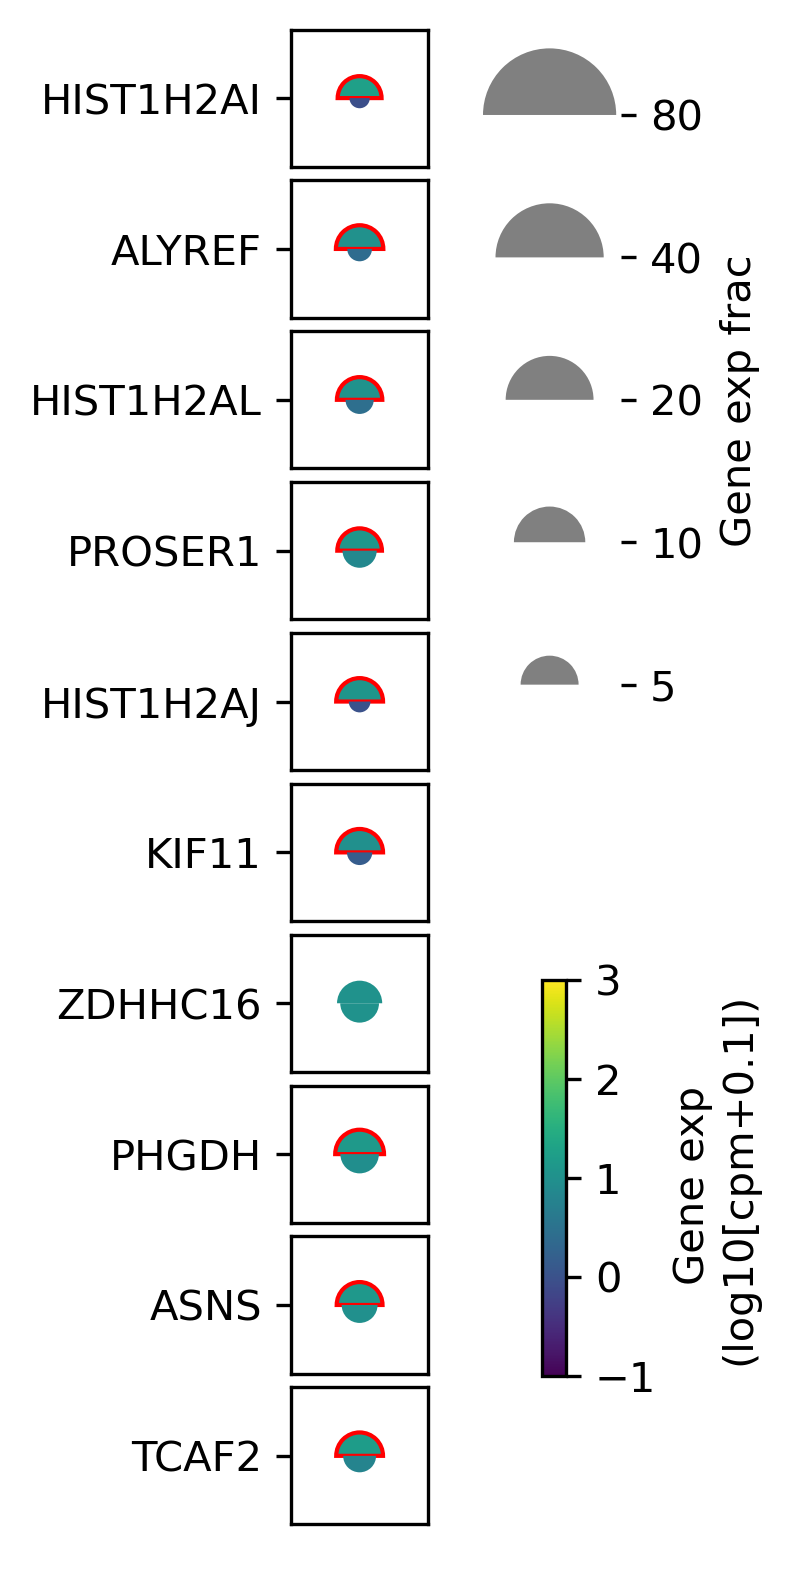

In [608]:
mush_top10(data_CD8)

<ipython-input-379-1513e3272b80>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1980 with 12 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

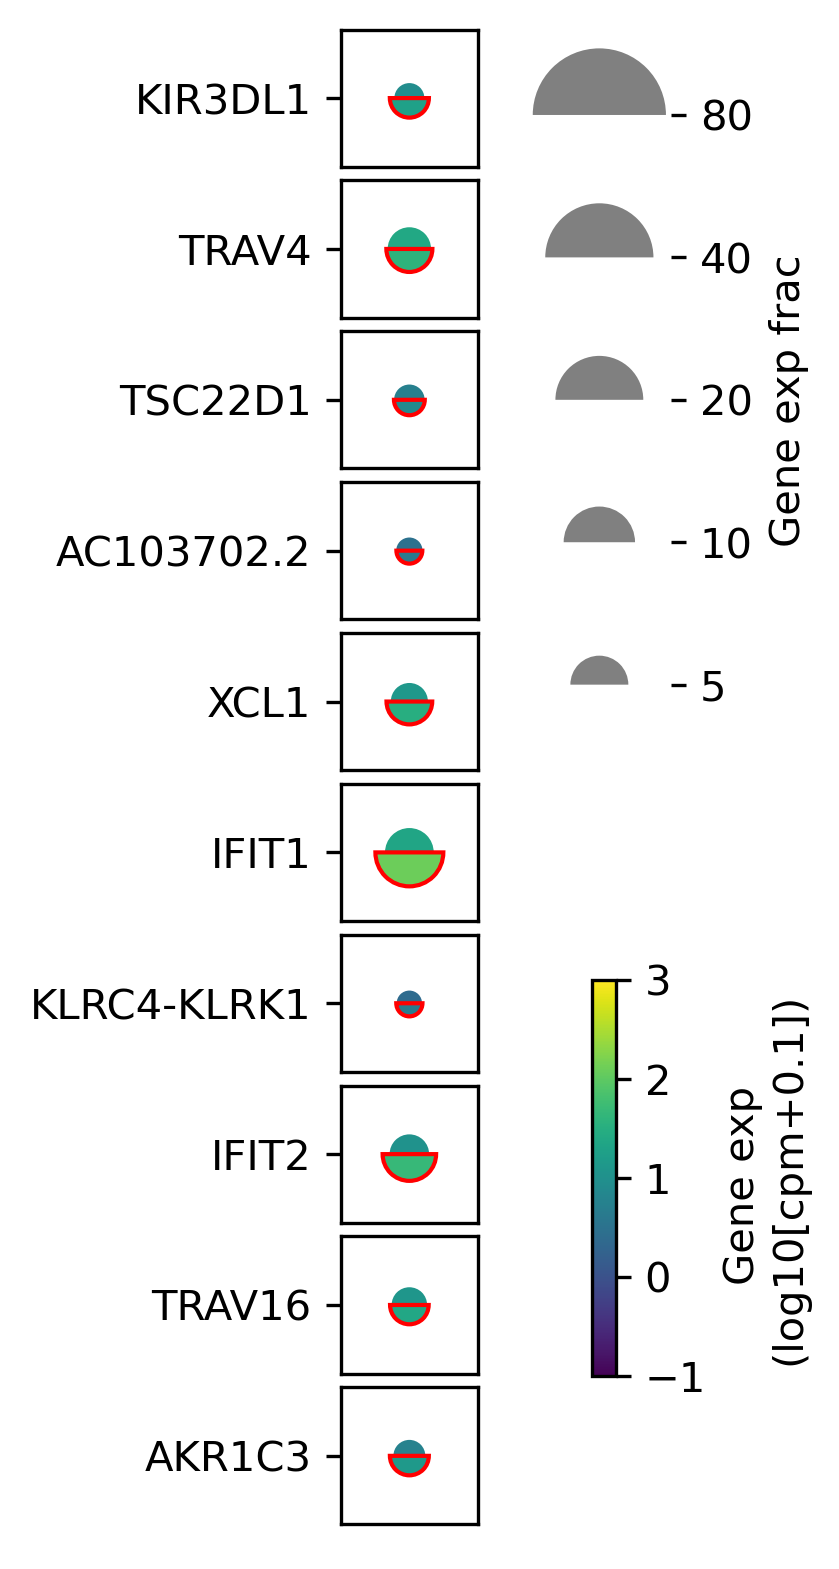

In [609]:
mush_last10(data_CD8)

In [210]:
adata_T = adata_children[(adata_children.obs['cell_type'] == 'T_cells') & (adata_children.obs['Condition'].isin(['S_dengue', 'dengue']))]

/home/yike/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:343: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


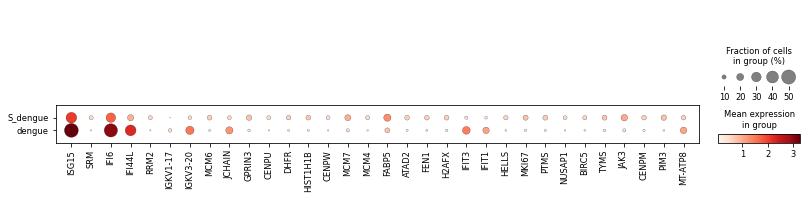

In [207]:
sc.pp.log1p(adata_T)
sc.pl.dotplot(adata_T, T_ls_top, groupby='Condition')

/home/yike/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:343: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


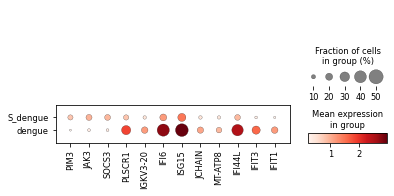

In [212]:
adata_CD4 = adata_T[adata_T.obs['cell_subtype_2'] == 'CD4_T_cells']
sc.pp.log1p(adata_CD4)
sc.pl.dotplot(adata_CD4, CD4_ls_top, groupby='Condition')

In [402]:
res = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_ks_no_filter.tsv', sep='\t', 
                  index_col=['cell_type', 'Unnamed: 0'])
pair = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/T_cells/pair.tsv', sep='\t', 
                   index_col=['cell_type', 'gene'])

# filter DEGs with log2 fold change >1 between two groups and a -log10(p-values) >10
res_f = res[(abs(res['log2_fold_change']) > 1) & 
           (- np.log10(res['pvalue']) > 10)]
ks_ls = res_f.index.tolist()
# CD8_cells: 117
# CD4_T_cells: 28
# T_cells: 51
# total: 196

idx = list(range(200)) + list(range(37907)[-200:])

pair_ls = []
for cell_type in ['T_cells', 'CD4_T_cells', 'CD8_T_cells']:
    pair_ls = pair_ls + [(cell_type, gene) for gene in pair.loc[cell_type].iloc[idx].index.tolist()]
    
overlap_ls = [gene for gene in pair_ls if gene in ks_ls]

T_ls = [idx[1] for idx in overlap_ls if idx[0] == 'T_cells']
CD4_ls = [idx[1] for idx in overlap_ls if idx[0] == 'CD4_T_cells']
CD8_ls = [idx[1] for idx in overlap_ls if idx[0] == 'CD8_T_cells']
# CD8_cells: 6
# CD4_T_cells: 1
# T_cells: 8
# total: 15

<ipython-input-77-981021a43d9e>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x17100 with 49 Axes>,
 'ax': [<AxesSubplot:title={'center':'LTA'}>,
  <AxesSubplot:title={'center':'TNFRSF1A'}>,
  <AxesSubplot:title={'center':'TNFRSF1B'}>,
  <AxesSubplot:title={'center':'TNFRSF14'}>,
  <AxesSubplot:title={'center':'IFNG'}>,
  <AxesSubplot:title={'center':'IFNGR1'}>,
  <AxesSubplot:title={'center':'IFNGR2'}>,
  <AxesSubplot:title={'center':'IL1A'}>,
  <AxesSubplot:title={'center':'IL1B'}>,
  <AxesSubplot:title={'center':'IL1R1'}>,
  <AxesSubplot:title={'center':'IL2'}>,
  <AxesSubplot:title={'center':'IL2RA'}>,
  <AxesSubplot:title={'center':'IL2RB'}>,
  <AxesSubplot:title={'center':'IL2RG'}>,
  <AxesSubplot:title={'center':'IL4'}>,
  <AxesSubplot:title={'center':'IL4R'}>,
  <AxesSubplot:title={'center':'IL5'}>,
  <AxesSubplot:title={'center':'IL5RA'}>,
  <AxesSubplot:title={'center':'IL6'}>,
  <AxesSubplot:title={'center':'IL6R'}>,
  <AxesSubplot:title={'center':'IL6ST'}>,
  <AxesSubplot:title={'center':'IL10'}>,
  <AxesSubplot:title={'center

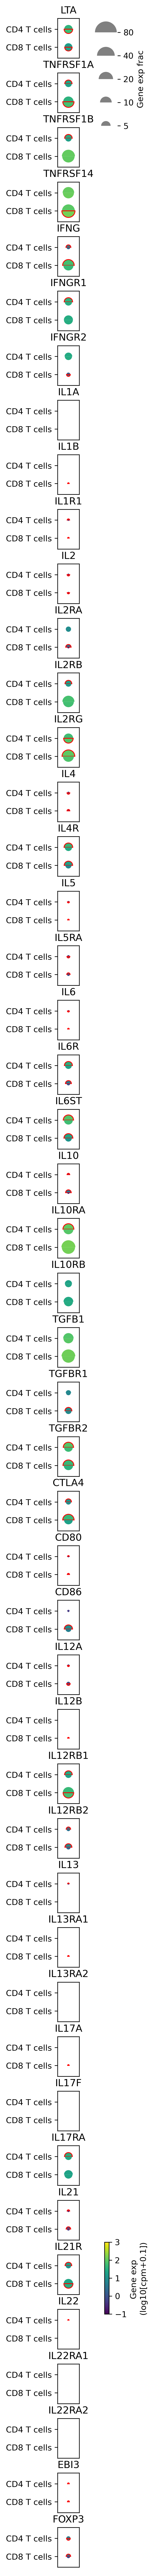

In [295]:
cyto_g = {'TNF-β': ['LTA', 'TNFRSF1A', 'TNFRSF1B', 'TNFRSF14'], 
        'IFN-γ': ['IFNG', 'IFNGR1', 'IFNGR2'],
        'IL-1': ['IL1A', 'IL1B', 'IL1R1'],
        'IL-2': ['IL2', 'IL2RA', 'IL2RB', 'IL2RG'],
        'IL-4': ['IL4', 'IL4R'],
        'IL-5': ['IL5', 'IL5RA'],
        'IL-6': ['IL6', 'IL6R', 'IL6ST'],
        'IL10': ['IL10', 'IL10RA', 'IL10RB'],
        'TGF-β': ['TGFB1', 'TGFBR1', 'TGFBR2'],
        'CTLA-4': ['CTLA4', 'CD80', 'CD86'],
        'IL-12': ['IL12A', 'IL12B', 'IL12RB1', 'IL12RB2'],
        'IL-13': ['IL13', 'IL13RA1', 'IL13RA2'],
        'IL-17': ['IL17A', 'IL17F', 'IL17RA'],
        'IL-21': ['IL21', 'IL21R'],
        'IL-22': ['IL22', 'IL22RA1', 'IL22RA2'],
        'IL-35': ['EBI3'],
        'POXP3': ['FOXP3']}
genes = list(itertools.chain.from_iterable(cyto_g.values()))
cyto_genes = []
for i, gene in enumerate(genes):
    cyto_genes.append({})
    cyto_genes[i][gene] = ['CD8_T_cells', 'CD4_T_cells']
s_mushrooms(cyto_genes)

In [5]:
def genes_correlation(adata_S, gene):
    from scipy.stats import spearmanr
    ar = adata_S.X.toarray()
    ast = adata_S[:, gene].X.toarray()[:, 0]

    c = {}
    for i, gene in enumerate(adata_S.var_names):
        if i%100 == 0:
            print(i)
        c[gene] = spearmanr(ar[:,i], ast)[0]

    c = pd.Series(c)
    c = c.fillna(0).sort_values(ascending=False)
    c = c.to_frame(name='r')
    c['rank'] = np.arange(c.shape[0])
    
    return c

In [6]:
adata_CD4 = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD4_T_cells')]
c_CD4 = genes_correlation(adata_CD4, 'CTLA4')

0


/usr/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [9]:
a = c_CD4.loc[['CTLA4', 'FOXP3', 'IL2RA', 'IL2RB']]
a.columns = ['Correlation', 'Rank']

In [10]:
a

,Correlation,Rank
CTLA4,1.000000,0
FOXP3,0.092981,30
IL2RA,0.051625,441
IL2RB,0.059457,201


In [ ]:
adata_CD8 = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD4_T_cells')]
c_CD4 = genes_correlation(adata_CD4, 'CTLA4')

In [11]:
adata_CD4_SD = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD4_T_cells') & (adata_children.obs['Condition'] == 'S_dengue')]
c_CD4_SD = genes_correlation(adata_CD4, 'CTLA4')

0
100
200


/usr/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600


In [29]:
a = c_CD4_SD.loc[['CTLA4', 'FOXP3', 'IL2RA', 'IL2RB']]

In [30]:
a.columns = ['r SD', 'rank SD']

In [31]:
b.columns = ['r D', 'rank D']

In [32]:
c = pd.concat([a, b], axis=1)

In [33]:
c

,r SD,rank SD,r D,rank D
CTLA4,1.000000,0,1.000000,0
FOXP3,0.098062,123,0.062936,465
IL2RA,0.060448,930,0.004592,6381
IL2RB,0.105173,93,0.013598,4935


In [14]:
adata_CD4_D = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD4_T_cells') & (adata_children.obs['Condition'] == 'dengue')]
c_CD4_D = genes_correlation(adata_CD4_D, 'CTLA4')

0
100
200
300
400
500


/usr/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18800


In [18]:
b = c_CD4_D.loc[['CTLA4', 'FOXP3', 'IL2RA', 'IL2RB']]

In [632]:
adata_CD8_SD = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD8_T_cells') & (adata_children.obs['Condition'] == 'S_dengue')]
c_CD8_SD = genes_correlation(adata_CD8_SD, 'CTLA4')

0
100
200
300
400


/usr/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18

In [635]:
c_CD8_SD.loc[['CTLA4', 'FOXP3', 'IL2RA', 'IL2RB']]

,r,rank
FOXP3,0.119036,5597
TLR4,0.000000,34808
IL2RA,0.137104,4632
IL2RB,0.255588,521


In [637]:
c_CD8_SD.loc['CD86']

r         0.259133
rank    490.000000
Name: CD86, dtype: float64

In [633]:
adata_CD8_D = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD8_T_cells') & (adata_children.obs['Condition'] == 'dengue')]
c_CD8_D = genes_correlation(adata_CD8_D, 'CTLA4')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [636]:
c_CD8_D.loc[['CTLA4', 'FOXP3', 'IL2RA', 'IL2RB']]

,r,rank
FOXP3,0.099552,1844
TLR4,0.111998,1188
IL2RA,0.101853,1691
IL2RB,0.098410,1919


In [638]:
c_CD8_D.loc['CD86']

r         0.139165
rank    433.000000
Name: CD86, dtype: float64

In [642]:
#adata_CD8_SD = adata_children[(adata_children.obs['cell_subtype_2'] == 'CD8_T_cells') & (adata_children.obs['Condition'] == 'S_dengue')]
c_CD8_SD_CD86 = genes_correlation(adata_CD8_SD, 'CD86')

0
100
200
300
400


/usr/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18

In [655]:
c_CD8_SD_CD86[:32]

,r,rank
CD86,1.000000,0
CCNB1,0.327525,1
UBE2S,0.325889,2
HMMR,0.324829,3
CDKN3,0.323131,4
CCNA2,0.322501,5
PLK1,0.319781,6
TUBA1B,0.318437,7
CDC20,0.318257,8
CCNB2,0.317004,9


In [647]:
c_CD8_D_CD86 = genes_correlation(adata_CD8_D, 'CD86')

0
100
200
300
400


/usr/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18

In [648]:
c_CD8_D_CD86.loc[['CTLA4', 'IL10', 'IL4', 'IFNG', 'LTA']]

,r,rank
CTLA4,0.139165,243
IL10,-0.005203,31690
IL4,0.000000,15539
IFNG,0.063865,2422
LTA,-0.005148,31339


In [650]:
c_CD4_FOX = genes_correlation(adata_CD4, 'FOXP3')

0
100


/usr/lib/python3.9/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18

In [654]:
c_CD4_FOX[:32]

,r,rank
FOXP3,1.000000,0
ANKS1B,0.257236,1
AC005392.2,0.249702,2
ARG1,0.204738,3
CHN1,0.189555,4
AC011997.1,0.175253,5
AC017002.3,0.171488,6
IL2RA,0.171075,7
IL7,0.166165,8
LINC02046,0.165834,9
